In [384]:
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import seaborn as sns


In [385]:
LOW_QUANTILE = 0.2
HIGH_QUANTILE = 0.8

# Create a Folder to Store the Results
import os

if not os.path.exists("Results" + "_" + str(LOW_QUANTILE) + "_" + str(HIGH_QUANTILE)):
    os.mkdir("Results" + "_" + str(LOW_QUANTILE) + "_" + str(HIGH_QUANTILE))
    
save_path = "Results" + "_" + str(LOW_QUANTILE) + "_" + str(HIGH_QUANTILE) + "/"

## Data

### mRNA Expression Data

In [386]:
mRNA_df = pd.read_csv('Depmap Melanoma mRNA.csv')
mRNA_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [387]:
full_mRNA_df = pd.read_csv('Depmap Pancancer mRNA.csv')
full_mRNA_df.drop(['Unnamed: 0'], axis=1, inplace=True)

### Gene Dependency Data

In [388]:
dependency_df = pd.read_csv('Depmap Melanoma Gene Dependency.csv')
dependency_df.drop(['Unnamed: 0'], axis=1, inplace=True)

### Cell Lines Data

In [389]:
cell_df = pd.read_csv('Depmap Melanoma Cells.csv')
cell_df.drop(['Unnamed: 0'], axis=1, inplace=True)

### VIP Data (VIP_M DF & VIP_U DF)

In [390]:
# Gene Dependency (4-vars) VIP Scores
vip_df = pd.read_csv(r'C:\Users\commo\OneDrive - University of Virginia\School\STEM\BME\BME 4700 - Systems Bioengineering\CCLE Chromatin Analysis\Models\Multivariable PLSR\Gene Dependency\VIP Scores\Gene Dependency (4-vars) VIP Scores.csv')
print(vip_df.shape)
vip_df.head(5)

(498, 5)


,Gene,M-TM,T-TM-TN,N-TN-NU,U-NU
0,ACTB,-1.565552,-1.489925,1.344195,1.524378
1,ACTL6A,-1.213636,-1.073693,1.061273,1.202825
2,ACTL6B,0.528281,0.517434,-0.481300,-0.518155
3,AKAP8,0.667250,0.766280,-0.584709,-0.621358
4,AKAP8L,1.537476,1.540888,-1.339207,-1.484803


##### VIP-M

In [391]:
# VIP-M = Genes with M-TM Score > 1.0 & U-NU < -1.0
vip_m = vip_df[(vip_df['M-TM'] > 1.0) & (vip_df['U-NU'] < -1.0)]
print(vip_m.shape)
vip_m.head(5)

(78, 5)


,Gene,M-TM,T-TM-TN,N-TN-NU,U-NU
4,AKAP8L,1.537476,1.540888,-1.339207,-1.484803
19,ASF1A,1.273099,1.353588,-1.087987,-1.206153
38,BCOR,1.084413,1.113473,-0.989359,-1.052571
40,BMI1,1.335860,1.327599,-1.463934,-1.374021
41,BPTF,1.787900,1.655963,-1.611635,-1.769182


##### VIP-U

In [392]:
# VIP-U = Genes with M-TM Score < -1.0 & U-NU > 1.0
vip_u = vip_df[(vip_df['M-TM'] < -1.0) & (vip_df['U-NU'] > 1.0)]
print(vip_u.shape)
vip_u.head(5)

(88, 5)


,Gene,M-TM,T-TM-TN,N-TN-NU,U-NU
0,ACTB,-1.565552,-1.489925,1.344195,1.524378
1,ACTL6A,-1.213636,-1.073693,1.061273,1.202825
6,APBB1,-1.024399,-0.891535,0.943952,1.029994
8,APP,-1.023702,1.063689,1.292265,1.095916
12,ARID3A,-1.143215,-0.998690,1.059495,1.150287


## Analysis

### Validating Assumptions / mRNA Quartiles

#### Normality Test (Shapiro-Wilk Test) for mRNA Expression and Gene Dependency

In [393]:
# Shapiro-Wilk Test for Normality for All Genes in Gene mRNA Expression Data
# Interpretation: p-value < 0.05, therefore  mRNA data is not normally distributed
results = []
for gene in mRNA_df.columns[1:]:
    results.append((gene,stats.shapiro(mRNA_df[gene])[0],stats.shapiro(mRNA_df[gene])[1]))
    
shapiro_df = pd.DataFrame(results, columns=['Gene','W-Stat','p-value'])
print(shapiro_df.shape)
print(mRNA_df.shape)
print('number of genes that are normally distributed: ', len(shapiro_df[shapiro_df['p-value'] > 0.05]))
    

c:\Users\commo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1797: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


(19193, 3)
(60, 19194)
number of genes that are normally distributed:  7925


In [394]:
# Shapiro-Wilk Test for Normality for All Genes in Gene Dependency Data
# Interpretation: p-value < 0.05, therefore  dependency data is not normally distributed

results = []
for gene in dependency_df.columns[1:]:
    results.append((gene,stats.shapiro(dependency_df[gene])[0],stats.shapiro(dependency_df[gene])[1]))
    
shapiro_df = pd.DataFrame(results, columns=['Gene','W-Stat','p-value'])
print(shapiro_df.shape)
print(dependency_df.shape)
print('number of genes that are normally distributed: ', len(shapiro_df[shapiro_df['p-value'] > 0.05]))

c:\Users\commo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1797: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


(17931, 3)
(60, 17932)
number of genes that are normally distributed:  371


#### mRNA Quartiles (Pancancer mRNA & Melanoma mRNA)

##### VIP-M mRNA Subset

In [395]:
# Subset mRNA for VIP-M Genes
mRNA_vip_m_df = mRNA_df[vip_m['Gene']]
print(mRNA_vip_m_df.shape)
print(vip_m.shape)

# Calulcate the all the quantiles for each gene in the mRNA data
m_mRNA_quantiles = mRNA_vip_m_df.quantile([LOW_QUANTILE, 0.5, HIGH_QUANTILE])

# Save
m_mRNA_quantiles.to_csv(save_path + '/Melanoma mRNA VIP-M Quantiles.csv')

m_mRNA_quantiles.head(5)

(60, 78)
(78, 5)


,AKAP8L,ASF1A,BCOR,BMI1,BPTF,BRD1,BRD4,CBX5,CBX8,CDYL,...,TAF5L,TET2,TNP1,TRIM24,TRIM28,UHRF2,WDR82,XBP1,ZBTB7B,ZMYND8
0.2,4.768607,3.064105,3.474436,4.332079,4.180784,2.902266,3.983106,4.062908,2.398268,3.468231,...,3.546919,1.228954,0.000000,2.975492,7.883510,3.939602,5.074412,5.918019,2.872517,4.327400
0.5,5.015247,3.718088,4.042627,4.728709,4.654777,3.611761,4.473449,4.430620,2.868868,3.892379,...,4.017392,1.769672,0.000000,3.351687,8.525503,4.354316,5.606120,6.307943,3.441590,4.972987
0.8,5.326967,4.177453,4.479726,5.072102,4.882246,4.072777,4.802971,5.081454,3.235772,4.399958,...,4.314696,2.289205,0.216602,3.796400,8.988079,4.955774,6.021333,6.803887,4.103463,5.322324


In [396]:
# Subset pan mRNA for VIP-M Genes
full_mRNA_vip_m_df = full_mRNA_df[vip_m['Gene']]
print(full_mRNA_vip_m_df.shape)
print(vip_m.shape)

# Calulcate the all the quantiles for each gene in the pan mRNA data
m_full_mRNA_quantiles = full_mRNA_vip_m_df.quantile([LOW_QUANTILE, 0.5, HIGH_QUANTILE])

# Save
m_full_mRNA_quantiles.to_csv(save_path + '/Pancancer mRNA VIP-M Quantiles.csv')

m_full_mRNA_quantiles.head(5)

(1407, 78)
(78, 5)


,AKAP8L,ASF1A,BCOR,BMI1,BPTF,BRD1,BRD4,CBX5,CBX8,CDYL,...,TAF5L,TET2,TNP1,TRIM24,TRIM28,UHRF2,WDR82,XBP1,ZBTB7B,ZMYND8
0.2,4.729118,3.294841,3.235727,4.128953,4.252779,3.208517,3.881665,4.126147,2.084064,3.362049,...,3.500802,1.536053,0.0,2.720716,8.014623,3.651224,4.926758,5.526569,3.160597,3.519793
0.5,5.148934,3.972693,3.899176,4.807870,4.827819,3.750607,4.475085,4.883132,2.666757,3.879706,...,4.004501,2.134221,0.0,3.418190,8.655602,4.357552,5.546277,6.271089,3.949535,4.266787
0.8,5.647142,4.579422,4.775999,5.516835,5.468974,4.311648,5.008989,5.549361,3.339706,4.386535,...,4.416299,2.752320,0.0,4.182851,9.269141,5.107688,6.056150,7.165550,4.744484,5.001712


##### VIP-U mRNA Subset

In [397]:
# Inner Join of vip_u and columns in mRNA_df
vip_u_genes = vip_u['Gene'].tolist()
mRNA_genes = mRNA_df.columns[1:].tolist()
intersection = list(set(vip_u_genes).intersection(mRNA_genes))

# Subset mRNA for VIP-M Genes
mRNA_vip_u_df = mRNA_df[intersection]
print(mRNA_vip_u_df.shape)
print(vip_u.shape)

# Calulcate the all the quantiles for each gene in the mRNA data
u_mRNA_quantiles = mRNA_vip_u_df.quantile([LOW_QUANTILE,0.5,HIGH_QUANTILE])

# Save
u_mRNA_quantiles.to_csv(save_path + '/Melanoma mRNA VIP-U Quantiles.csv')

u_mRNA_quantiles.head(5)

(60, 87)
(88, 5)


,TAF9,MSL1,MAP3K7,HMGN2,INCENP,IWS1,USP22,PRMT3,NAP1L4,SMARCAL1,...,RBBP7,APBB1,KDM3A,ACTL6A,MUC1,JMJD4,NOC2L,TAF12,PBRM1,PAF1
0.2,6.167153,5.050064,3.778629,8.436070,4.214894,4.936714,5.843136,3.869050,6.245341,3.447577,...,6.407194,3.730629,4.229264,6.087320,0.808692,3.326315,5.841714,4.149454,3.753604,4.693360
0.5,6.604425,5.437787,4.098449,8.864604,5.050703,5.270526,6.165122,4.295932,6.525626,3.828280,...,7.026766,4.291309,4.544387,6.487839,1.592140,4.029675,6.565673,4.594248,4.167097,5.327147
0.8,7.021111,5.785795,4.333563,9.372323,5.585277,5.571858,6.522075,4.671160,6.864411,4.066243,...,7.374865,4.743405,5.059224,6.756959,2.532372,4.387525,7.144035,4.878235,4.698995,5.631046


In [398]:
# Subset mRNA for VIP-M Genes
full_mRNA_vip_u_df = full_mRNA_df[intersection]
print(full_mRNA_vip_u_df.shape)
print(vip_u.shape)

# Calulcate the all the quantiles for each gene in the mRNA data
u_full_mRNA_quantiles = full_mRNA_vip_u_df.quantile([LOW_QUANTILE,0.5,HIGH_QUANTILE])

# Save
u_full_mRNA_quantiles.to_csv(save_path + '/Pancancer mRNA VIP-U Quantiles.csv')

u_full_mRNA_quantiles.head(5)

(1407, 87)
(88, 5)


,TAF9,MSL1,MAP3K7,HMGN2,INCENP,IWS1,USP22,PRMT3,NAP1L4,SMARCAL1,...,RBBP7,APBB1,KDM3A,ACTL6A,MUC1,JMJD4,NOC2L,TAF12,PBRM1,PAF1
0.2,5.837590,5.093560,3.621993,8.335792,4.067978,4.809208,5.382529,3.688404,6.095967,3.214125,...,6.514248,0.661745,3.695994,6.105175,1.405992,3.305386,5.694880,4.086784,3.297778,4.952893
0.5,6.396262,5.560104,4.137504,9.038178,4.884109,5.223036,6.130931,4.231125,6.589164,3.701549,...,7.042863,2.992768,4.201634,6.593204,3.003602,3.819668,6.307975,4.617063,4.106851,5.509379
0.8,6.879534,6.045312,4.593831,9.777738,5.507287,5.578516,6.676803,4.791189,7.014199,4.099127,...,7.600998,4.496973,4.738984,7.073841,5.160275,4.312374,6.871351,5.055976,4.800538,6.030159


### T-Tests Between mRNA Quartiles

#### VIP-M mRNA Quartile T-Tests

In [399]:
results = []
m_gene_groups = pd.DataFrame()

for gene in vip_m['Gene']:
    # Index by gene column and then quantile row index
    low_expression = m_full_mRNA_quantiles[gene][LOW_QUANTILE]
    
    # Testing for > 25th percentile or < 75th percentile
    high_expression = m_full_mRNA_quantiles[gene][HIGH_QUANTILE]
    
    # Create a filter and then index by the gene column
    low_expression_cells = mRNA_df[mRNA_df[gene] <= low_expression][['Cell Line',gene]]
    high_expression_cells = mRNA_df[mRNA_df[gene] > high_expression][['Cell Line',gene]]
    
    # T-Test of Gene mRNA Levels in Low and High Expression Cells
    ttest = stats.ttest_ind(low_expression_cells[gene], high_expression_cells[gene],  alternative = 'two-sided')
    
    # Append the results to the results list
    # Format: (Gene, Low Samples, Low Expression Mean, High Samples High Expression Mean, T-Stat, P-Value)
    results.append((gene, len(low_expression_cells), low_expression_cells[gene].mean(), len(high_expression_cells), high_expression_cells[gene].mean(), ttest[0], ttest[1]))
    
    # Add a column to the low expression cells called "Group" and assign it the value "low"
    low_expression_cells['Group'] = 'low'
    high_expression_cells['Group'] = 'high'
    
    # Sort the cells by cell line so that they are in the same order as the gene_groups dataframe
    expression = pd.concat([low_expression_cells, high_expression_cells])
    expression.sort_values(by=['Cell Line'], inplace=True)
    
    # Append the low and high expression cells to the gene_groups list
    m_gene_groups = pd.concat([m_gene_groups, expression['Group']], axis=1)
    m_gene_groups.rename(columns={'Group': gene}, inplace=True)
    
    
    
m_ttest_df = pd.DataFrame(results, columns=['Gene','Low Samples','Low Expression Mean','High Samples','High Expression Mean','T-Stat','P-Value'])
print(m_ttest_df.shape)
print("Number of Genes with Significant Difference in Expression: ", len(m_ttest_df[m_ttest_df['P-Value'] < 0.05]))
m_ttest_df.head(5)
    


C:\Users\commo\AppData\Local\Temp\ipykernel_42632\2400055132.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ttest = stats.ttest_ind(low_expression_cells[gene], high_expression_cells[gene],  alternative = 'two-sided')
c:\Users\commo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1253: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\commo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1253: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\commo\AppData\Local\Temp\ipykernel_42632\2400055132.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are

(78, 7)
Number of Genes with Significant Difference in Expression:  65


C:\Users\commo\AppData\Local\Temp\ipykernel_42632\2400055132.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ttest = stats.ttest_ind(low_expression_cells[gene], high_expression_cells[gene],  alternative = 'two-sided')
c:\Users\commo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1253: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\commo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1253: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


,Gene,Low Samples,Low Expression Mean,High Samples,High Expression Mean,T-Stat,P-Value
0,AKAP8L,11,4.452027,3,5.957156,-9.809033,4.409075e-07
1,ASF1A,20,2.883121,3,4.802379,-10.077252,1.692877e-09
2,BCOR,8,3.068376,5,4.947236,-42.381016,1.537090e-13
3,BMI1,7,3.742965,1,5.517906,NaN,NaN
4,BPTF,16,3.979720,2,5.741758,-7.088475,2.566740e-06


In [400]:
print(m_gene_groups.shape)
# where m_genes is null
print(m_gene_groups.loc[:,m_gene_groups.isnull().any(axis=0)].columns)
m_gene_groups.head(5)


(60, 78)
Index(['AKAP8L', 'ASF1A', 'BCOR', 'BMI1', 'BPTF', 'BRD1', 'BRD4', 'CBX5',
       'CBX8', 'CDYL', 'CDYL2', 'CENPA', 'CHD8', 'CRTC2', 'CTCF', 'CTNNB1',
       'CXXC1', 'DR1', 'EHMT1', 'EHMT2', 'EP300', 'EPC2', 'HMGN3', 'IRF4',
       'KAT6A', 'KDM1A', 'KDM2B', 'KDM4C', 'KDM5C', 'L3MBTL1', 'L3MBTL2',
       'LCOR', 'LEF1', 'MBD2', 'MLLT1', 'MLLT3', 'NCOA1', 'NEDD4', 'NIPBL',
       'NR1H4', 'PAXIP1', 'PCGF1', 'PML', 'PRDM6', 'PRMT6', 'PRMT7', 'RBBP5',
       'RCOR1', 'RING1', 'RLF', 'RRP8', 'RUVBL2', 'SATB2', 'SETD1B', 'SETDB1',
       'SGF29', 'SIRT7', 'SMARCA4', 'SMCHD1', 'SNAI2', 'SUV39H1', 'SUZ12',
       'TADA1', 'TADA3', 'TAF4', 'TAF5L', 'TET2', 'TRIM24', 'TRIM28', 'UHRF2',
       'WDR82', 'XBP1', 'ZBTB7B', 'ZMYND8'],
      dtype='object')


,AKAP8L,ASF1A,BCOR,BMI1,BPTF,BRD1,BRD4,CBX5,CBX8,CDYL,...,TAF5L,TET2,TNP1,TRIM24,TRIM28,UHRF2,WDR82,XBP1,ZBTB7B,ZMYND8
7,high,NaN,NaN,NaN,NaN,NaN,high,NaN,high,high,...,NaN,NaN,high,low,NaN,high,NaN,high,NaN,high
9,low,low,NaN,NaN,low,high,NaN,NaN,high,high,...,NaN,NaN,low,low,NaN,low,high,NaN,NaN,NaN
17,low,low,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,high,NaN,NaN,NaN,high,NaN,NaN,high
25,low,low,low,low,NaN,low,low,low,NaN,NaN,...,low,low,low,NaN,low,low,low,NaN,low,NaN
26,high,high,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,high,low,NaN,NaN,NaN,high,high,NaN,NaN


In [401]:
# Write to CSV
m_ttest_df.sort_values(by=['Low Samples','High Samples'], ascending=[False,True], inplace=True)
m_ttest_df.reset_index(drop=True, inplace=True)
m_ttest_df.to_csv(save_path + 'M mRNA T-Test Results( less ' + str(LOW_QUANTILE) + ' greater ' + str(HIGH_QUANTILE) + ' ).csv')

#### VIP-U mRNA Quartile T-Tests

In [402]:

results = []
u_gene_groups = pd.DataFrame()

for gene in intersection:
    # Index by gene column and then quantile row index
    low_expression = u_full_mRNA_quantiles[gene][LOW_QUANTILE]
    
    # Testing for > 25th percentile or < 75th percentile
    high_expression = u_full_mRNA_quantiles[gene][HIGH_QUANTILE]
    
    # Create a filter and then index by the gene column
    low_expression_cells = mRNA_df[mRNA_df[gene] <= low_expression][['Cell Line',gene]]
    high_expression_cells = mRNA_df[mRNA_df[gene] > high_expression][['Cell Line',gene]]
    
    # T-Test of Gene mRNA Levels in Low and High Expression Cells
    ttest = stats.ttest_ind(low_expression_cells[gene], high_expression_cells[gene],  alternative = 'two-sided')
    
    # Append the results to the results list
    # Format: (Gene, Low Samples, Low Expression Mean, High Samples High Expression Mean, T-Stat, P-Value)
    results.append((gene, len(low_expression_cells), low_expression_cells[gene].mean(), len(high_expression_cells), high_expression_cells[gene].mean(), ttest[0], ttest[1]))
    
    # Add a column to the low expression cells called "Group" and assign it the value "low"
    low_expression_cells['Group'] = 'low'
    high_expression_cells['Group'] = 'high'
    
    # Sort the cells by cell line so that they are in the same order as the gene_groups dataframe
    expression = pd.concat([low_expression_cells, high_expression_cells])
    expression.sort_values(by=['Cell Line'], inplace=True)
    
    # Append the low and high expression cells to the gene_groups list
    u_gene_groups = pd.concat([u_gene_groups, expression['Group']], axis=1)
    u_gene_groups.rename(columns={'Group': gene}, inplace=True)
    
u_ttest_df = pd.DataFrame(results, columns=['Gene','Low Samples','Low Expression Mean','High Samples','High Expression Mean','T-Stat','P-Value'])
print(u_ttest_df.shape)
print("Number of Genes with Significant Difference in Expression: ", len(u_ttest_df[u_ttest_df['P-Value'] < 0.05]))
u_ttest_df.head(5)
    


C:\Users\commo\AppData\Local\Temp\ipykernel_42632\2485671006.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ttest = stats.ttest_ind(low_expression_cells[gene], high_expression_cells[gene],  alternative = 'two-sided')
c:\Users\commo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1253: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\commo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1253: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\commo\AppData\Local\Temp\ipykernel_42632\2485671006.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are

(87, 7)
Number of Genes with Significant Difference in Expression:  68


C:\Users\commo\AppData\Local\Temp\ipykernel_42632\2485671006.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ttest = stats.ttest_ind(low_expression_cells[gene], high_expression_cells[gene],  alternative = 'two-sided')
c:\Users\commo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1253: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\commo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1253: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


,Gene,Low Samples,Low Expression Mean,High Samples,High Expression Mean,T-Stat,P-Value
0,TAF9,7,5.545760,17,7.174407,-12.971218,8.793420e-12
1,MSL1,15,4.873680,4,6.269305,-11.794246,1.310406e-09
2,MAP3K7,9,3.309527,4,4.830614,-10.878526,3.167478e-07
3,HMGN2,9,8.041883,3,10.089006,-9.350730,2.930586e-06
4,INCENP,9,3.537317,14,6.036830,-10.600570,6.910671e-10


In [403]:
print(u_gene_groups.shape)
# where u_genes is null
print(u_gene_groups.loc[:,u_gene_groups.isnull().any(axis=0)].columns)
u_gene_groups.head(5)

(60, 87)
Index(['TAF9', 'MSL1', 'MAP3K7', 'HMGN2', 'INCENP', 'IWS1', 'USP22', 'PRMT3',
       'NAP1L4', 'SMARCAL1', 'LMNA', 'TAF1', 'TAF10', 'SCMH1', 'WDR5B',
       'KMT5A', 'NPM2', 'HSPBAP1', 'RNF40', 'PHC1', 'SMYD5', 'PRKD1', 'CREBBP',
       'MYOD1', 'AUTS2', 'WDR5', 'NAA50', 'SMARCD3', 'HELLS', 'GATAD2A',
       'INO80', 'MSL2', 'MBD3', 'MTF2', 'GATA2', 'PHF20L1', 'EPC1', 'SETD5',
       'PAXBP1', 'ATF2', 'ACTB', 'HDAC3', 'SMARCE1', 'MORF4L1', 'ELK4',
       'ZNHIT1', 'SUDS3', 'APP', 'TAF2', 'HIRIP3', 'KDM8', 'RTF1', 'LPIN1',
       'BRPF3', 'MCRS1', 'KDM4D', 'KDM4A', 'KMT2A', 'SMARCA1', 'DYDC2', 'CHD1',
       'BAZ2B', 'BRMS1L', 'PER2', 'DDX11', 'SNW1', 'ZBTB33', 'SAFB', 'NCOR1',
       'ARID3A', 'NTMT1', 'BCL6', 'MTHFR', 'LDB1', 'BRD7', 'SIRT4', 'BAZ2A',
       'RBBP7', 'APBB1', 'KDM3A', 'ACTL6A', 'MUC1', 'JMJD4', 'NOC2L', 'TAF12',
       'PBRM1', 'PAF1'],
      dtype='object')


,TAF9,MSL1,MAP3K7,HMGN2,INCENP,IWS1,USP22,PRMT3,NAP1L4,SMARCAL1,...,RBBP7,APBB1,KDM3A,ACTL6A,MUC1,JMJD4,NOC2L,TAF12,PBRM1,PAF1
3,high,low,NaN,NaN,low,low,NaN,NaN,NaN,high,...,NaN,NaN,NaN,low,NaN,high,high,NaN,NaN,NaN
7,high,NaN,NaN,NaN,low,NaN,NaN,high,high,NaN,...,NaN,NaN,NaN,NaN,low,high,NaN,high,NaN,NaN
10,low,NaN,NaN,high,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,high,NaN,high,NaN,NaN,NaN,NaN
13,low,NaN,NaN,NaN,NaN,NaN,NaN,low,NaN,NaN,...,low,high,high,NaN,NaN,NaN,NaN,NaN,NaN,high
16,high,NaN,NaN,NaN,high,NaN,NaN,NaN,NaN,NaN,...,high,NaN,NaN,NaN,NaN,NaN,high,NaN,NaN,high


In [404]:
# Write to CSV
u_ttest_df.sort_values(by=['Low Samples','High Samples'], ascending=[False,True], inplace=True)
u_ttest_df.reset_index(drop=True, inplace=True)
u_ttest_df.to_csv(save_path + 'U mRNA T-Test Results( less ' + str(LOW_QUANTILE) + ' greater ' + str(HIGH_QUANTILE) + ' ).csv')

### T-Tests for Chronos Scores by mRNA Groups

In [405]:
# Concatenate the gene groups dataframes
gene_groups = pd.concat([m_gene_groups, u_gene_groups], axis=1)
gene_groups = gene_groups.reindex(sorted(gene_groups.columns), axis=1)
print(gene_groups.shape)
gene_groups.head(5)

(60, 165)


,ACTB,ACTL6A,AKAP8L,APBB1,APP,ARID3A,ASF1A,ATF2,AUTS2,BAZ2A,...,UHRF2,USP22,WDR5,WDR5B,WDR82,XBP1,ZBTB33,ZBTB7B,ZMYND8,ZNHIT1
7,NaN,NaN,high,NaN,NaN,NaN,NaN,NaN,NaN,high,...,high,NaN,NaN,high,NaN,high,NaN,NaN,high,NaN
9,NaN,NaN,low,high,NaN,NaN,low,low,NaN,NaN,...,low,high,high,low,high,NaN,low,NaN,NaN,NaN
17,NaN,NaN,low,NaN,NaN,NaN,low,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,high,NaN,low,NaN,high,high
25,NaN,low,low,NaN,high,low,low,NaN,NaN,low,...,low,NaN,low,low,low,NaN,low,low,NaN,high
26,NaN,NaN,high,NaN,high,low,high,high,NaN,low,...,NaN,NaN,low,high,high,high,NaN,NaN,NaN,NaN


In [406]:
# Concatenate the vip genes dataframes
vip_genes = pd.concat([vip_m['Gene'], pd.Series(intersection)], axis=0)
vip_genes.sort_values(inplace=True)
vip_genes.reset_index(drop=True, inplace=True)
print(vip_genes.shape)
vip_genes.head(5)

(165,)


0      ACTB
1    ACTL6A
2    AKAP8L
3     APBB1
4       APP
dtype: object

In [407]:
 # Create a Matrix of Gene x Gene
gene_effect_matrix = np.zeros((gene_groups.shape[1], gene_groups.shape[1])) 
print(gene_effect_matrix.shape)

# Iterate through the genes
# For each gene, grab the low and high expression cell lines from the gene_groups dataframe
# Iterate through the other expression cell lines and then grab the gene dependency values
# from depdenency_df, index by the index of the cell line
for gene in vip_genes:
    low_expression = gene_groups[gene_groups[gene] == 'low'].index
    high_expression = gene_groups[gene_groups[gene] == 'high'].index
    
    for gene2 in vip_genes:
        low_expression_dependency = dependency_df.loc[low_expression, gene2]
        high_expression_dependency = dependency_df.loc[high_expression, gene2]
        
        # T-Test of Gene Dependency in Low and High Expression Cells
        ttest = stats.ttest_ind(low_expression_dependency, high_expression_dependency,  alternative = 'two-sided')
        
        # Add the t-statistic to the gene effect matrix
        gene_effect_matrix[vip_genes[vip_genes == gene].index[0], vip_genes[vip_genes == gene2].index[0]] = ttest[1]
        
# Save
np.savetxt(save_path + 'mRNA vs. Gene Dependency Matrix.csv', gene_effect_matrix, delimiter=",")

(165, 165)


C:\Users\commo\AppData\Local\Temp\ipykernel_42632\190217022.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ttest = stats.ttest_ind(low_expression_dependency, high_expression_dependency,  alternative = 'two-sided')
c:\Users\commo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1253: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\commo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1253: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [408]:
# Convert to PD
gene_effect_matrix_df = pd.DataFrame(gene_effect_matrix, columns=vip_genes, index=vip_genes)

# Remove NaN rows
gene_effect_matrix = gene_effect_matrix[~np.isnan(gene_effect_matrix).any(axis=1)]

In [409]:
# Rows where the p-value is less than 0.05
significant_rows_df = gene_effect_matrix_df[gene_effect_matrix_df < 0.05]
significant_rows_df.head(5)



,ACTB,ACTL6A,AKAP8L,APBB1,APP,ARID3A,ASF1A,ATF2,AUTS2,BAZ2A,...,UHRF2,USP22,WDR5,WDR5B,WDR82,XBP1,ZBTB33,ZBTB7B,ZMYND8,ZNHIT1
ACTB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACTL6A,NaN,NaN,NaN,0.007094,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.039988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AKAP8L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.031963,NaN,NaN,NaN,NaN,NaN
APBB1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
APP,NaN,NaN,NaN,0.015469,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [410]:
# Heatmap
sns.set(font_scale=4.5)
plt.figure(figsize=(125,125))
sns.heatmap(significant_rows_df, vmin=0, vmax=0.05, cmap='rocket', xticklabels=True, yticklabels=True)

# Save
plt.savefig(save_path + 'mRNA vs. Gene Dependency Heatmap.png', dpi=300, bbox_inches='tight', format = 'png')


(6,)
(17,)
(6,)
(17,)


Text(0.5, 1.0, 'RRP8 mRNA in Low and High Expression Cells')

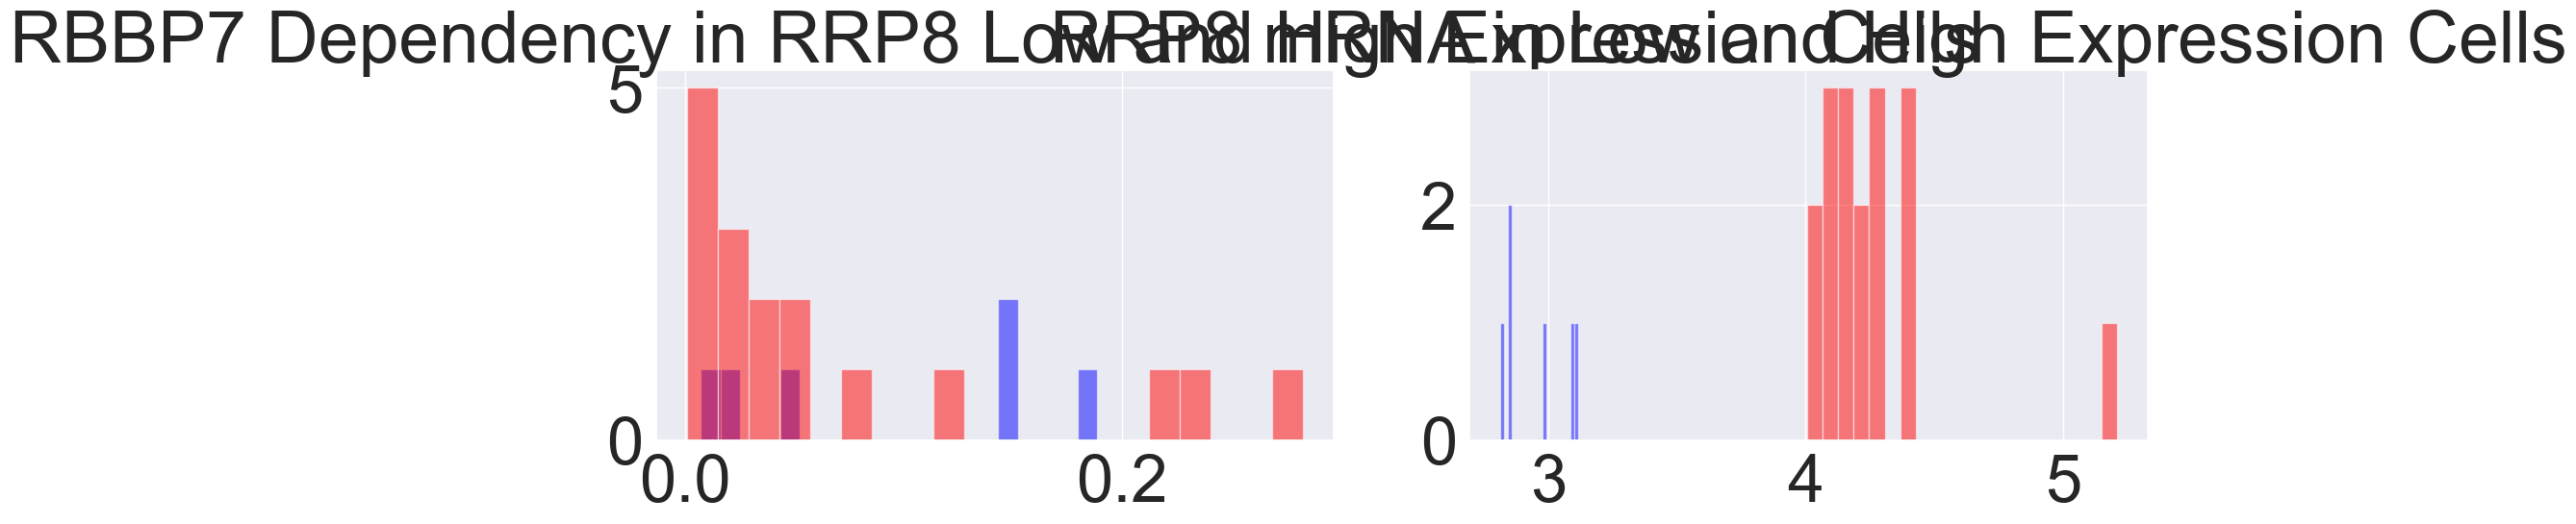

In [411]:
# Manual Validation
gene = 'RRP8'
gene2 = 'RBBP7'
low_expression = gene_groups[gene_groups[gene] == 'low'].index
high_expression = gene_groups[gene_groups[gene] == 'high'].index
print(low_expression.shape)
print(high_expression.shape)

low_expression_dependency = dependency_df.loc[low_expression, gene2]
high_expression_dependency = dependency_df.loc[high_expression, gene2]
print(low_expression_dependency.shape)
print(high_expression_dependency.shape)

# T-Test of Gene Dependency in Low and High Expression Cells
ttest = stats.ttest_ind(low_expression_dependency, high_expression_dependency,  alternative = 'two-sided')

# Add the t-statistic to the gene effect matrix
gene_effect_matrix[vip_genes[vip_genes == gene].index[0], vip_genes[vip_genes == gene2].index[0]] = ttest[0]

fig,ax = plt.subplots(1,2,figsize=(20,5))

ax[0].hist(low_expression_dependency, bins=20, color='blue', alpha=0.5, label='Low Expression')
ax[0].hist(high_expression_dependency, bins=20, color='red', alpha=0.5, label='High Expression')
ax[0].set_title(gene2 + ' Dependency in ' + gene + ' Low and High Expression Cells')

# mRNA
ax[1].hist(mRNA_df.loc[low_expression, gene], bins=20, color='blue', alpha=0.5, label='Low Expression')
ax[1].hist(mRNA_df.loc[high_expression, gene], bins=20, color='red', alpha=0.5, label='High Expression')
ax[1].set_title(gene + ' mRNA in Low and High Expression Cells')
    